# Post-Processing Sampling Results

In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/Research/Bump10MSun`


In [2]:
using ArviZ
using Bump10MSun
using DimensionalData
using Distributions
using GaussianKDEs
using HDF5
using LaTeXStrings
using Printf
using StatsBase
using StatsPlots
using Trapz
using Turing

## Preliminaries

In [3]:
default(palette=:batlowS)

## Load Traces, Check Convergence

In [4]:
traces = Dict(k => from_netcdf(joinpath(@__DIR__, "..", "chains", "chain" * suffix_map[k] * ".nc")) for k in keys(suffix_map))

Dict{Tuple{MassFunction, PowerLawPairing}, InferenceData{(:posterior, :sample_stats)}} with 2 entries:
  (BrokenPowerLaw(), Power… => InferenceData{(:posterior, :sample_stats), Tuple…
  (PowerLawGaussian(), Pow… => InferenceData{(:posterior, :sample_stats), Tuple…

Let's check for convergence:

In [5]:
for (k, t) in pairs(traces)
    println(k)
    @printf("  Min Neff_sel = %.1f (4*Nobs = %d)\n", minimum(t.posterior[:Neff_sel]), 4*length(t.posterior.m1s_popwt[draw=At(1), chain=At(1)]))
    @printf("  Min Neff_samps = %.1f\n", minimum(t.posterior[:Neff_samps]))
end

(BrokenPowerLaw(), PowerLawPairing())
  Min Neff_sel = 387.9 (4*Nobs = 80)
  Min Neff_samps = 6.8
(PowerLawGaussian(), PowerLawPairing())
  Min Neff_sel = 197.9 (4*Nobs = 80)
  Min Neff_samps = 4.9


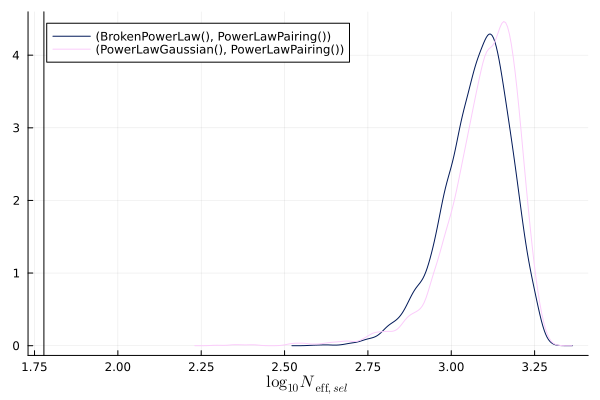

In [6]:
p = plot(xlabel=L"\log_{10} N_{\mathrm{eff}, sel}")
for (k, t) in pairs(traces)
    p = density!(log10.(vec(t.posterior.Neff_sel)), label=string(k))
end
p = vline!([log10(60)], color=:black, label=nothing)
p

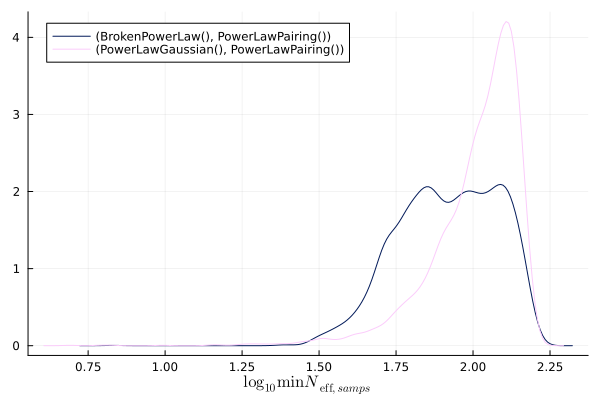

In [7]:
p = plot(xlabel=L"\log_{10} \min N_{\mathrm{eff}, samps}")
for (k, t) in pairs(traces)
    p = density!(log10.(vec(minimum(t.posterior.Neff_samps, dims=:gwnames))), label=string(k))
end
p

And we can take a quick look at the traceplots:

(BrokenPowerLaw(), PowerLawPairing())
(PowerLawGaussian(), PowerLawPairing())


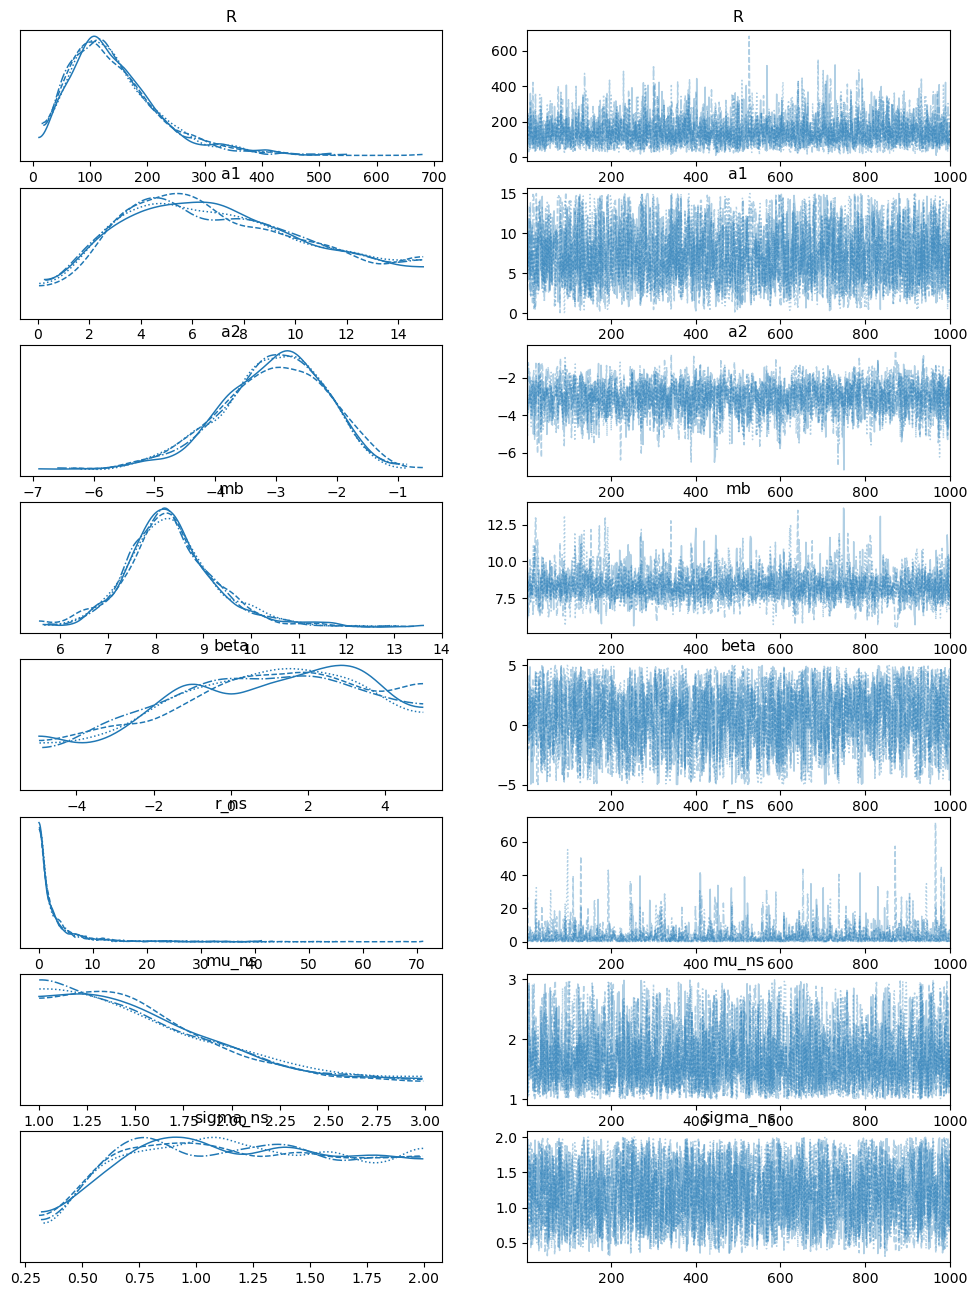

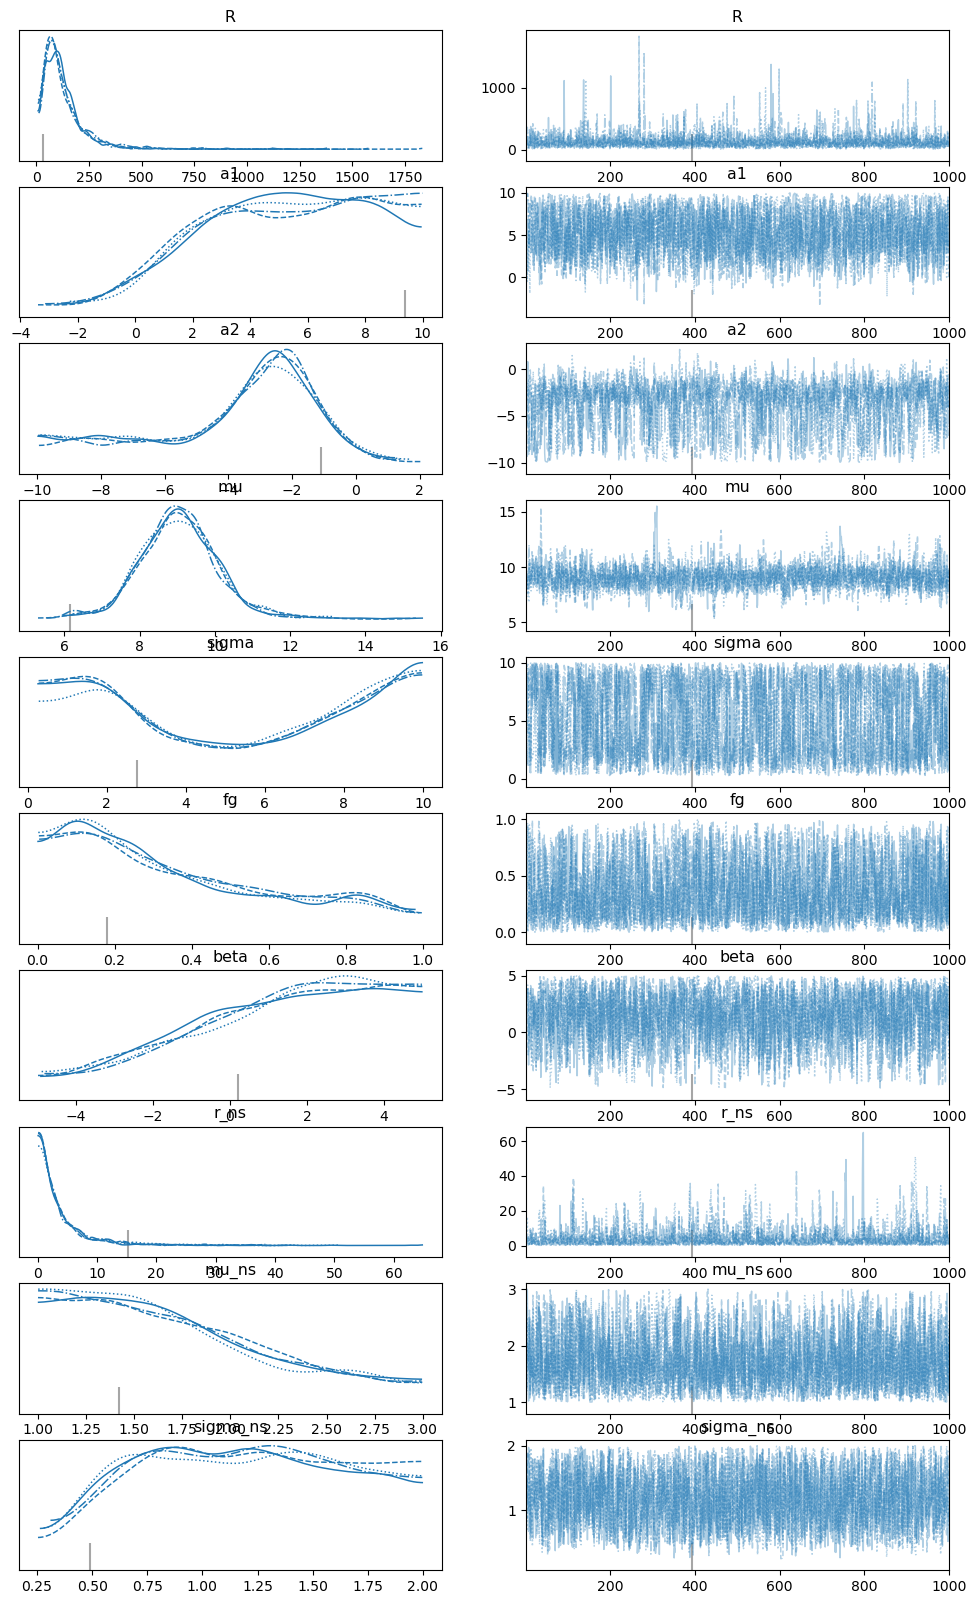

In [8]:
for (k, t) in pairs(traces)
    println(k)
    plot_trace(t, var_names=var_name_map[k[1:2]])
end

In [9]:
for (k, t) in pairs(traces)
    println(k)
    display(summarystats(t, var_names=var_name_map[k[1:2]]))
end

(BrokenPowerLaw(), PowerLawPairing())


8×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_b ⋯
     │ String    Float64  Float64  Float64  Float64  Float64    Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ R         143.32    79.068   23.486  288.445      1.23     0.895    408 ⋯
   2 │ a1          7.266    3.7      1.634   14.524      0.069    0.051    279
   3 │ a2         -3.054    0.871   -4.725   -1.518      0.019    0.014    198
   4 │ mb          8.342    0.991    6.605   10.331      0.021    0.015    227
   5 │ beta        0.613    2.565   -3.746    4.997      0.059    0.042    183 ⋯
   6 │ r_ns        3.304    5.365    0.02    11.062      0.118    0.083    182
   7 │ mu_ns       1.675    0.504    1.0      2.667      0.009    0.007    329
   8 │ sigma_ns    1.202    0.449    0.525    1.997      0.009    0.007    239
                                                               3 columns omitted

(PowerLawGaussian(), PowerLawPairing())


10×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_b ⋯
     │ String    Float64  Float64  Float64  Float64  Float64    Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ R         127.854  117.415    7.315  291.642      2.271    1.606    302 ⋯
   2 │ a1          5.337    2.784    0.911    9.951      0.065    0.048    162
   3 │ a2         -3.744    2.546   -9.306   -0.206      0.098    0.069     73
   4 │ mu          9.051    1.053    7.182   11.156      0.028    0.02     159
   5 │ sigma       5.115    3.287    0.668    9.995      0.121    0.086     91 ⋯
   6 │ fg          0.362    0.268    0.001    0.854      0.007    0.005    178
   7 │ beta        1.397    2.373   -2.824    4.997      0.053    0.037    190
   8 │ r_ns        4.002    5.451    0.024   12.347      0.139    0.102    174
   9 │ mu_ns       1.711    0.502    1.0      2.656      0.01     0.007    243 ⋯
  10 │ sigma_ns    1.188    0.447    0.49     1.973      0.009    0.007    212
                                                               3 columns omitted

## Mass Functions

In [10]:
dNdm1dm2_map = Dict(k => map([traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    ldN = make_log_dN(k[1], k[2], args[2:end]...)
    (m1, m2) -> args[1]*exp(ldN(m1, m2))         
end for k in keys(traces))
dNdm1_map = Dict(k => map([traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdm1(k[1], k[2], args[2:end]...)
    m1 -> args[1]*dN(m1)
end for k in keys(traces))
dNdm2_map = Dict(k => map([traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdm2(k[1], k[2], args[2:end]...)
    m2 -> args[1]*dN(m2)
end for k in keys(traces))
dNdq_map = Dict(k => map([traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdq(k[1], k[2], args[2:end]...)
    q -> args[1]*dN(q)
end for k in keys(traces))
pm_map = Dict(k => map([traces[k].posterior[v] for v in vcat(mf_var_name_map[k[1]], ns_var_names)]...) do args...
    make_dNdm(k[1], args[2:end]...)
end for k in keys(traces))

Dict{Tuple{MassFunction, PowerLawPairing}, DimArray{T, 2, Tuple{Dim{:draw, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}, Dim{:chain, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}}, Tuple{}, A, Symbol, DimensionalData.Dimensions.LookupArrays.NoMetadata} where {T, A<:AbstractMatrix{T}}} with 2 entries:
  (BrokenPowerLaw(), Power… => var"#18#19"{BrokenPowerLaw, NTuple{6, Float64}}[…
  (PowerLawGaussian(), Pow… => var"#18#19"{PowerLawGaussian, NTuple{8, Float64}…

In [11]:
ms = exp.(log(m_lower_limit):0.01:log(m_upper_limit))
ms = ms[2:end-1]
qs = collect(range(m_lower_limit/m_upper_limit, 1, length=129))[2:end]

function make_mean_map(xs, dN_map)
    Dict(
        k => begin
            dN_mean = zeros(length(xs))
            for dN in v
                dN_mean .= dN_mean .+ dN.(xs)
            end
            dN_mean .= dN_mean ./ length(v)
            dN_mean
        end
        for (k,v) in pairs(dN_map)
    )
end

dN1_mean_map = make_mean_map(ms, dNdm1_map)
dN2_mean_map = make_mean_map(ms, dNdm2_map)
dNq_mean_map = make_mean_map(qs, dNdq_map)

Dict{Tuple{MassFunction, PowerLawPairing}, Vector{Float64}} with 2 entries:
  (BrokenPowerLaw(), Power… => [17.0354, 34.3475, 52.2188, 71.5205, 93.114, 117…
  (PowerLawGaussian(), Pow… => [17.0022, 31.2726, 46.4633, 63.6169, 82.4887, 10…

In [12]:
dN1_mean_map[BrokenPowerLaw(), PowerLawPairing()]

390-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.033929509122679724
 0.0327669951424789
 0.03154840298881903
 0.030374371049526665
 0.029243264461066825
 0.028247471437717307
 0.027196404510069144
 0.026183760263751098
 0.025208154941569378
 0.02426825704091508
 0.023448409423054054
 0.022574848261570673

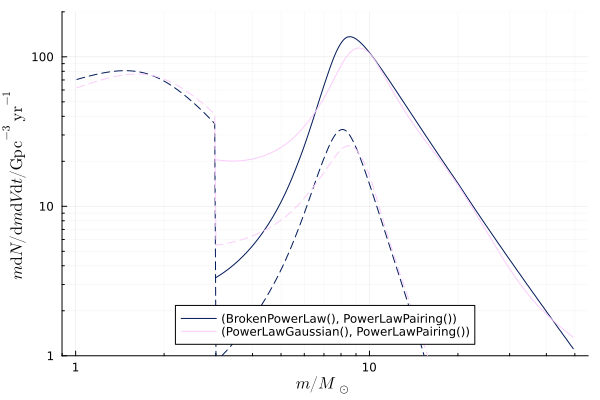

In [13]:
i = 1
p = plot(xlabel=L"m / M_\odot", ylabel=L"m \mathrm{d} N / \mathrm{d} m \mathrm{d} V \mathrm{d} t / \mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}", formatter=s->@sprintf("%.0f", s), minorgrid=true, yscale=:log10, ylims=(1, 200), xscale=:log10)
for mf in [BrokenPowerLaw(), PowerLawGaussian()]
    pf = PowerLawPairing()
    k = (mf, pf)
    v = dN1_mean_map[k]
    p = plot!(ms, ms .* v, label=string(k), color=i)
    p = plot!(ms, ms .* dN2_mean_map[k], label=nothing, color=i, linestyle=:dash)
    i += 1
end
p = plot!(legend_position=:bottom)
p

How about the "common" part of the mass function?

In [14]:
pm_mean_map = Dict(
    k => begin
        pm = zeros(length(ms))
        for v in pm_map[k]
            p = v.(ms)
            p = p ./ trapz(ms, p)
            pm = pm .+ p
        end
        pm = pm / length(pm_map[k])
        pm
    end
    for k in keys(traces)
)

Dict{Tuple{MassFunction, PowerLawPairing}, Vector{Float64}} with 2 entries:
  (BrokenPowerLaw(), Power… => [0.629828, 0.626884, 0.623925, 0.620947, 0.61795…
  (PowerLawGaussian(), Pow… => [0.622283, 0.619552, 0.616812, 0.614062, 0.61130…

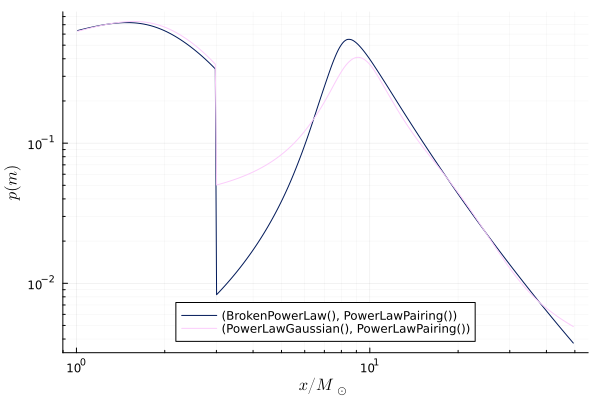

In [15]:
p = plot(xlabel=L"x/M_\odot", ylabel=L"p(m)", yscale=:log10, xscale=:log10, minorgrid=true, legend_position=:bottom)
for mf in [BrokenPowerLaw(), PowerLawGaussian()]
    k = (mf, PowerLawPairing())
    v = pm_mean_map[k]
    p = plot!(ms, ms.*v, label=string(k))
end
p

What about $\mathrm{d} N / \mathrm{d} q \mathrm{d} V \mathrm{d} t$?

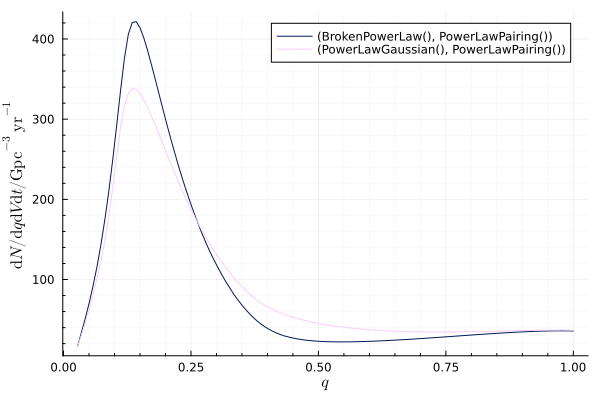

In [16]:
p = plot(xlabel=L"q", ylabel=L"\mathrm{d} N / \mathrm{d} q \mathrm{d} V \mathrm{d} t / \mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}", minorgrid=true)

for mf in [BrokenPowerLaw(), PowerLawGaussian()]
    pf = PowerLawPairing()
    k = (mf,pf)

    p = plot!(qs, dNq_mean_map[k], label=string(k))
end
p

## Peak Locations

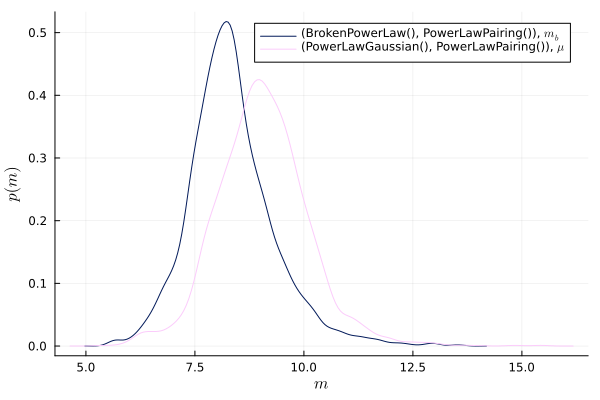

In [17]:
p = plot(xlabel=L"m", ylabel=L"p(m)")
for k in keys(traces)
    if k[1] === BrokenPowerLaw()
        p = density!(vec(traces[k].posterior.mb), label=string(k) * L", $m_b$")
    elseif k[1] === PowerLawGaussian()
        p = density!(vec(traces[k].posterior.mu), label=string(k) * L", $\mu$")
    end
end
p

The Gaussian + Power Law mass scale seems to be the best localized, so let's plot that alone:

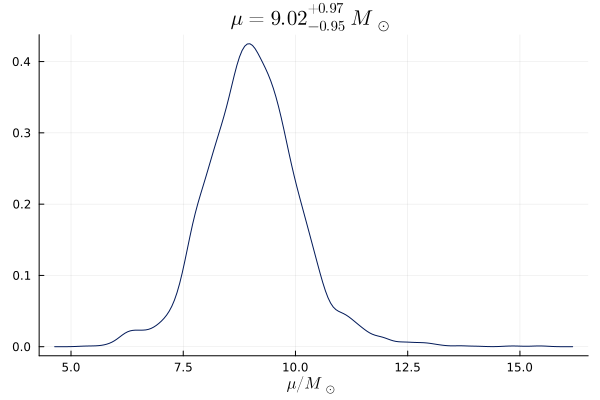

In [18]:
t = traces[(PowerLawGaussian(), PowerLawPairing())]
x = vec(t.posterior.mu)
m = median(x)
l = quantile(x, 0.16)
h = quantile(x, 0.84)

density(x, xlabel=L"\mu / M_\odot", title=@sprintf("\$\\mu = %.2f^{+%.2f}_{-%.2f} \\, M_\\odot\$", m, h-m, m-l), label=nothing)

## $m_{1\%}$

Here again we will look with the Gaussian + Power Law model:

In [19]:
function m1pct(f, mmin=3.0)
    ms = exp.(log(mmin):0.01:log(m_upper_limit))
    fm = f.(ms)
    cfm = cumtrapz(ms, fm)

    ms[argmin(abs.(cfm/cfm[end] .- 0.01))]
end

m1pct (generic function with 2 methods)

We begin with $m_{1\%}$ for the 50% selection:

In [20]:
m1pct_m1 = Dict(
    k => map(v) do dN
        m1pct(dN)
    end
    for (k,v) in pairs(dNdm1_map)
)
m1pct_m2 = Dict(
    k => map(v) do dN
        m1pct(dN)
    end
    for (k,v) in pairs(dNdm2_map)
)
m1pct_m = Dict(
    k => map(v) do dN
        m1pct(dN)
    end
    for (k,v) in pairs(pm_map)
)

Dict{Tuple{MassFunction, PowerLawPairing}, DimArray{Float64, 2, Tuple{Dim{:draw, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}, Dim{:chain, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}}, Tuple{}, Matrix{Float64}, Symbol, DimensionalData.Dimensions.LookupArrays.NoMetadata}} with 2 entries:
  (BrokenPowerLaw(), Power… => [6.22524 5.35812 4.00928 5.46636; 5.19976 5.5212…
  (PowerLawGaussian(), Pow… => [3.12243 3.59165 3.0606 3.12243; 3.0606 3.0606 3…

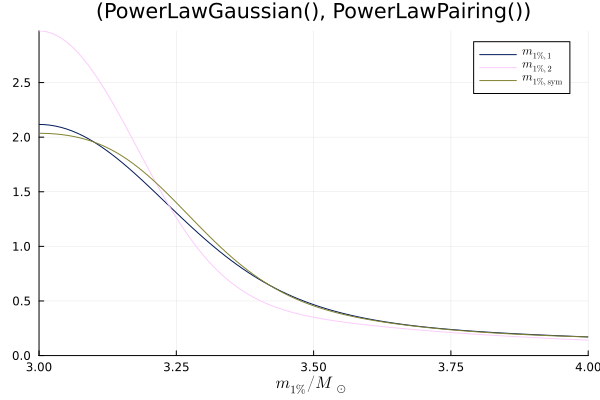

In [21]:
m1ps = 3:0.01:4
ymax = 1.6

k = (PowerLawGaussian(), PowerLawPairing())

p = plot(xlabel=L"m_{1\%} / M_\odot", xlims=(3, 4), title=string(k), ylims=(0, Inf))
for (i, (ms, lab)) in enumerate(zip([m1pct_m1[k], m1pct_m2[k], m1pct_m[k]], [L"m_{1\%,1}", L"m_{1\%,2}", L"m_{1\%,\mathrm{sym}}"]))
    m = vec(ms)
    p = plot!(m1ps, pdf.((BoundedKDE(m, lower=3),), m1ps), label=lab, color=i)
end
p

In [22]:
k = (PowerLawGaussian(), PowerLawPairing())
m1p = m1pct_m[k]
m = median(vec(m1p))
ll,l,h,hh = quantile.((vec(m1p),), [0.025, 0.16, 0.84, 0.975]) # hdi_interval(vec(m1p), 0.68)

@printf("%s: m_1%% = %.3f + %.3f - %.3f (1-sigma) or [%.1f - %.1f] (2-sigma)\n", string(k), m, h-m, m-l, ll, hh)

(PowerLawGaussian(), PowerLawPairing()): m_1% = 3.218 + 1.040 - 0.126 (1-sigma) or [3.1 - 5.7] (2-sigma)


## Individual Masses

Let's do some model checking.  First, we plot the population-informed posteriors for $m_1$ and $m_2$:

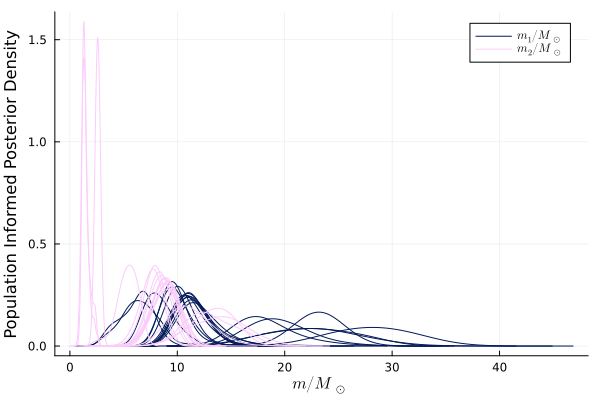

In [23]:
p = plot(xlabel=L"m / M_\odot", ylabel="Population Informed Posterior Density")
m1label = L"m_1 / M_\odot"
for n in DimensionalData.index(t.posterior, :gwnames)
    x = vec(t.posterior.m1s_popwt[gwnames=At(n)])
    p = density!(x, color=1, label=m1label, bandwidth=0.1*median(x))
    m1label = nothing
end
m2label = L"m_2 / M_\odot"
for n in DimensionalData.index(t.posterior, :gwnames)
    x = vec(t.posterior.m2s_popwt[gwnames=At(n)])
    p = density!(x, color=2, label=m2label, bandwidth=0.1*median(x))
    m2label = nothing
end
p

I bet our inference about the minimum BH mass is being driven by that one outlier.  Let's look:

In [24]:
nmin = ""
mmin = Inf
for n in DimensionalData.index(t.posterior, :gwnames)
    mm = minimum(t.posterior.m2s_popwt[gwnames=At(n)])

    if mm < mmin
        mmin = mm
        nmin = n
    end
    println("minimum(m2, $(n)): $(mm)")
end

println("Overall minimum is $(nmin)")

minimum(m2, GW190412): 7.431738379015872
minimum(m2, GW190426_152155): 0.8536851888663942
minimum(m2, GW190512_180714): 8.63427015564566
minimum(m2, GW190707_093326): 6.6062946546005925
minimum(m2, GW190708_232457): 8.868204618250898
minimum(m2, GW190720_000836): 5.008099929558597
minimum(m2, GW190728_064510): 5.962747498156095
minimum(m2, GW190814): 2.345925218996287
minimum(m2, GW190828_065509): 7.49152462948708
minimum(m2, GW190924_021846): 2.1883337949863355
minimum(m2, GW190930_133541): 4.367099074977496
minimum(m2, GW191103_012549): 5.325025076159053
minimum(m2, GW191105_143521): 6.03748115914678
minimum(m2, GW191129_134029): 5.144477922529303
minimum(m2, GW191204_171526): 6.6843891921515155
minimum(m2, GW191216_213338): 5.279166590364818
minimum(m2, GW200115_042309): 0.9859754444830618
minimum(m2, GW200202_154313): 5.490017316978767
minimum(m2, GW200225_060421): 9.074836927120227
minimum(m2, GW200316_215756): 6.0667115366397
Overall minimum is GW190426_152155


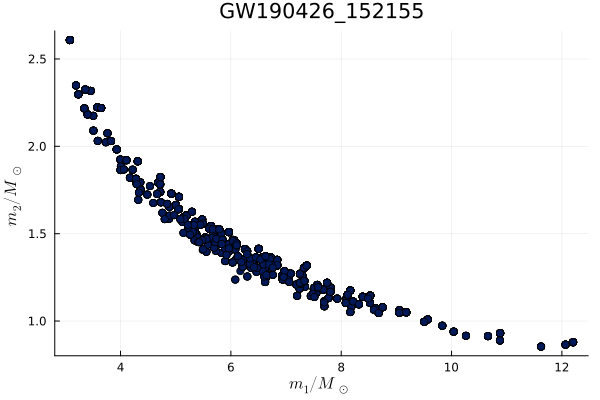

In [25]:
post = t.posterior
scatter(vec(post.m1s_popwt[gwnames=At(nmin)]), vec(post.m2s_popwt[gwnames=At(nmin)]), label=nothing, xlabel=L"m_1 / M_\odot", ylabel=L"m_2 / M_\odot", title=nmin)